In [1]:
# Sets seeds for reproducability.

import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import *
from accuracy import *
from transformers import get_linear_schedule_with_warmup
from model import Model
from torch import nn

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions_train=[8], num_actions_valid=6, batch_size=4, epochs=25, lr=0.001, MAX_DETECTIONS=20):    
    train_datasets = [YouCookII(num_action, "/h/sagar/ece496-capstone/datasets/ycii") for num_action in num_actions_train]
    valid_dataset = YouCookII(num_actions_valid, "/h/sagar/ece496-capstone/datasets/ycii")
    
    train_size = sum([len(train_dataset) for train_dataset in train_datasets])
    valid_size = len(valid_dataset)
    
    print("Training Dataset Size: {}, Validation Dataset Size: {}".format(train_size, valid_size))
        
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloaders = [DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
                         for train_dataset in train_datasets]
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    valid_accuracy = np.zeros(epochs)
    
    for epoch in range(epochs):
        model.train()
        
        epoch_loss = 0.
        num_batches = 0
        
        total = 0
        correct = 0
        
        for train_dataloader in train_dataloaders:
            for data in train_dataloader:
                _, bboxes, features, steps, entities, entity_count, _, _ = data

                # Zero out any gradients.
                optimizer.zero_grad()

                # Run inference (forward pass).
                loss_data, VG, RR = model(steps, features, bboxes, entities, entity_count)

                # Loss from alignment.
                loss_ = compute_loss_batched(loss_data)

                # Backpropagation (backward pass).
                loss_.backward()

                # Update parameters.
                optimizer.step()

                epoch_loss += loss_
                num_batches += 1
            
        # Scheduler update.
        scheduler.step()
        epoch_loss = epoch_loss / (num_batches * batch_size)
        
        # Save loss and accuracy at each epoch and plot.
        train_loss[epoch] = float(epoch_loss)
        train_accuracy[epoch] = get_alignment_accuracy(model, train_dataloader, batch_size) 
        
        valid_loss[epoch] = get_alignment_loss(model, valid_dataloader, batch_size)
        valid_accuracy[epoch] = get_alignment_accuracy(model, valid_dataloader, batch_size)

        print("Epoch {} - Train Loss: {:.2f}, Validation Loss: {:.2f}, Train Accuracy: {:.2f}, Validation Accuracy: {:.2f}"
              .format(epoch + 1, train_loss[epoch], valid_loss[epoch], train_accuracy[epoch], valid_accuracy[epoch]))
    
    plt.figure()
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    
    plt.figure()
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.legend()
    
    plt.show()
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)

Training Dataset Size: 283, Validation Dataset Size: 66
Epoch 1 - Train Loss: 937.49, Validation Loss: 641.63, Train Accuracy: 0.52, Validation Accuracy: 0.51
Epoch 2 - Train Loss: 907.36, Validation Loss: 626.51, Train Accuracy: 0.53, Validation Accuracy: 0.51
Epoch 3 - Train Loss: 916.82, Validation Loss: 610.89, Train Accuracy: 0.52, Validation Accuracy: 0.50
Epoch 4 - Train Loss: 892.13, Validation Loss: 608.32, Train Accuracy: 0.50, Validation Accuracy: 0.48
Epoch 5 - Train Loss: 893.69, Validation Loss: 600.46, Train Accuracy: 0.52, Validation Accuracy: 0.52
Epoch 6 - Train Loss: 885.92, Validation Loss: 623.77, Train Accuracy: 0.52, Validation Accuracy: 0.50
Epoch 7 - Train Loss: 873.44, Validation Loss: 618.09, Train Accuracy: 0.55, Validation Accuracy: 0.50
Epoch 8 - Train Loss: 847.50, Validation Loss: 603.74, Train Accuracy: 0.55, Validation Accuracy: 0.52
Epoch 9 - Train Loss: 833.36, Validation Loss: 605.93, Train Accuracy: 0.55, Validation Accuracy: 0.51
Epoch 10 - Train 

Epoch 80 - Train Loss: 17.85, Validation Loss: 592.28, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 81 - Train Loss: 17.24, Validation Loss: 607.02, Train Accuracy: 0.94, Validation Accuracy: 0.57
Epoch 82 - Train Loss: 18.16, Validation Loss: 578.55, Train Accuracy: 0.94, Validation Accuracy: 0.56
Epoch 83 - Train Loss: 17.24, Validation Loss: 574.88, Train Accuracy: 0.93, Validation Accuracy: 0.56
Epoch 84 - Train Loss: 16.95, Validation Loss: 573.58, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 85 - Train Loss: 16.92, Validation Loss: 589.70, Train Accuracy: 0.95, Validation Accuracy: 0.56
Epoch 86 - Train Loss: 16.28, Validation Loss: 588.95, Train Accuracy: 0.94, Validation Accuracy: 0.57
Epoch 87 - Train Loss: 16.21, Validation Loss: 582.19, Train Accuracy: 0.95, Validation Accuracy: 0.56
Epoch 88 - Train Loss: 16.64, Validation Loss: 578.69, Train Accuracy: 0.95, Validation Accuracy: 0.57
Epoch 89 - Train Loss: 16.73, Validation Loss: 570.55, Train Accuracy: 0.

Epoch 159 - Train Loss: 13.66, Validation Loss: 597.80, Train Accuracy: 0.95, Validation Accuracy: 0.56
Epoch 160 - Train Loss: 13.44, Validation Loss: 581.96, Train Accuracy: 0.95, Validation Accuracy: 0.57
Epoch 161 - Train Loss: 13.72, Validation Loss: 583.63, Train Accuracy: 0.95, Validation Accuracy: 0.56
Epoch 162 - Train Loss: 13.70, Validation Loss: 589.98, Train Accuracy: 0.95, Validation Accuracy: 0.55
Epoch 163 - Train Loss: 13.79, Validation Loss: 574.18, Train Accuracy: 0.96, Validation Accuracy: 0.56
Epoch 164 - Train Loss: 14.02, Validation Loss: 596.07, Train Accuracy: 0.95, Validation Accuracy: 0.57
Epoch 165 - Train Loss: 14.13, Validation Loss: 586.17, Train Accuracy: 0.96, Validation Accuracy: 0.56
Epoch 166 - Train Loss: 13.36, Validation Loss: 598.23, Train Accuracy: 0.95, Validation Accuracy: 0.57
Epoch 167 - Train Loss: 13.70, Validation Loss: 592.21, Train Accuracy: 0.95, Validation Accuracy: 0.55
Epoch 168 - Train Loss: 13.58, Validation Loss: 583.18, Train Ac

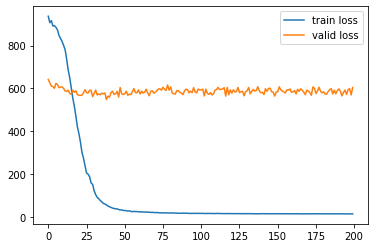

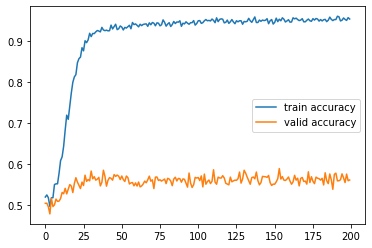

In [4]:
# Trainer.

num_actions_train = [3, 4, 5, 7, 8, 9, 10]
num_actions_valid = 6
batch_size = 16
epochs = 200
lr = 5e-5

train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data = train(
    model, 
    num_actions_train=num_actions_train,
    num_actions_valid=num_actions_valid,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr
)

In [5]:
# Evaluation.

from eval_fi import eval_all_dataset
eval_all_dataset(model, path="/h/sagar/ece496-capstone/datasets/fi")

--------------------------------------------------
Action 1: in a bowl, add ground beef, salt, pepper, 1 egg, dijon mustard and bread crumbs
Best IoU possible = 0.814872145652771
Random Candidate IoU = 0.582001805305481
Chosen Frame IoU: 0.26270750164985657
Best IoU possible = 0.617510199546814
Random Candidate IoU = 0.4274914562702179
Chosen Frame IoU: 0.4502232074737549
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: mix the ingredients with hand
Best IoU possible = 0.6298992037773132
Random Candidate IoU = 0.35797545313835144
Chosen Frame IoU: 0.5334117412567139
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add vegetable oil in a pan
Best IoU possible = 0.7462273240089417
Random Candidate I

--------------------------------------------------
Action 1: cut the cabbage into small pieces
Best IoU possible = 0.792510986328125
Random Candidate IoU = 0.15674004882813705
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: Add carawat seeds, sea salt
Best IoU possible = 0.11877390742301941
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.06320293247699738
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: mix them evenly in the cabbage
Best IoU possible = 0.22755128145217896
Random Candidate IoU = 0.10723605006933212
Chosen Frame IoU: 0.0
Best IoU possible = 0.9315666928471509
Random Candidate IoU = 0.054621756076812744
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 4: Add some leftover brine in a jar
Best IoU possible = 0.23314441740512848
Random Candidate IoU = 0.07153001427650452
Chosen Frame IoU: 0.23314441740512848
B

Best IoU possible = 0.6534976959228516
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.5243271589279175
Best IoU possible = 0.6940541863441467
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.09200742840766907
--------------------------------------------------
Action 9: Pour the marinade over the ribs
Best IoU possible = 0.8909910917282104
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.015336582437157631
Best IoU possible = 0.6414624282497835
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.5150278210639954
Mean Upper Bound IoU: 0.5877581834793091, Mean Random IoU: 0.0609055794775486, Mean Model IoU: 0.21091648936271667
Top-1 acc@0.5:
Proposal Upper Bound: 0.7333333333333333, Random: 0.0, Model: 0.13333333333333333
--------------------------------------------------
Action 1: boil water in a pot with salt and oil
Best IoU possible = 0.7798901796340942
Random Candidate IoU = 0.35059577226638794
Chosen Frame IoU: 0.7798901796340942
Best IoU possible = 0.5936298370361328
Random Candidate IoU = 

Random Candidate IoU = 0.1814092993736267
Chosen Frame IoU: 0.5313036441802979
--------------------------------------------------
Action 7: spread some sauce
Best IoU possible = 0.30627989768981934
Random Candidate IoU = 0.19799844920635223
Chosen Frame IoU: 0.25776585936546326
--------------------------------------------------
Action 8: add ham, shredded cheese and more sauce and ham
Best IoU possible = 0.6280260682106018
Random Candidate IoU = 0.23917365074157715
Chosen Frame IoU: 0.382689505815506
Best IoU possible = 0.6028886437416077
Random Candidate IoU = 0.5467394590377808
Chosen Frame IoU: 0.39181235432624817
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 9: Cover it with another piece of bread
Best IoU possible = 0.7562223672866821
Random Candidate IoU = 0.24228504300117493
Chosen Frame IoU: 0.24883416295051575
Best IoU possible = 0.7463744282722473
Random Candidate IoU = 0.102

Best IoU possible = 0.6841245889663696
Random Candidate IoU = 0.09449581056833267
Chosen Frame IoU: 0.24357199668884277
--------------------------------------------------
Action 2: Melt butter in a pan
Best IoU possible = 0.5938389301300049
Random Candidate IoU = 0.39860716462135315
Chosen Frame IoU: 0.0
Best IoU possible = 0.6172184944152832
Random Candidate IoU = 0.10962848365306854
Chosen Frame IoU: 0.29972055554389954
--------------------------------------------------
Action 3: mix the flour with the butter
Best IoU possible = 0.5315556078534311
Random Candidate IoU = 0.3286047577857971
Chosen Frame IoU: 0.36937087774276733
Best IoU possible = 0.528659110126503
Random Candidate IoU = 0.23465509712696075
Chosen Frame IoU: 0.4107210338115692
--------------------------------------------------
Action 4: Stir milk into the rue
Best IoU possible = 0.775029182434082
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.41184964776039124
Best IoU possible = 0.34250765790693266
Random Candidate Io

Best IoU possible = 0.45863819122314453
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.09585055090014866
--------------------------------------------------
Action 8: Add the sauce and udon noodles to the pan
Best IoU possible = 0.7526325583457947
Random Candidate IoU = 0.40296006202697754
Chosen Frame IoU: 0.5019660592079163
Best IoU possible = 0.46342578530311584
Random Candidate IoU = 0.1664249747991562
Chosen Frame IoU: 0.42282456159591675
This entity has no ground truth bounding box
--------------------------------------------------
Action 9: stir
No entities detected for this action.
--------------------------------------------------
Action 10: place watercress on the dish
Best IoU possible = 0.5940109491348267
Random Candidate IoU = 0.04150065407156944
Chosen Frame IoU: 0.4816833734512329
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the stir-fry on top of the watercress
Best IoU possible = 0.7481353878974915
Rand

--------------------------------------------------
Action 1: Add the meat to a bowl
Best IoU possible = 0.6369763016700745
Random Candidate IoU = 0.6007891443465666
Chosen Frame IoU: 0.48175984621047974
Best IoU possible = 0.7723944783210754
Random Candidate IoU = 0.7246986031532288
Chosen Frame IoU: 0.7246986031532288
--------------------------------------------------
Action 2: Add garlic salt, sugar, sesame oil, and sauce to the meat
Best IoU possible = 0.7261868715286255
Random Candidate IoU = 0.12640167772769928
Chosen Frame IoU: 0.2341594099998474
Best IoU possible = 0.6844748258590698
Random Candidate IoU = 0.14724017679691315
Chosen Frame IoU: 0.2510136067867279
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add cabbage, green onion, and carrots to the bowl
Best IoU possible = 0.3534908938807178
Random Candidate IoU = 0.152514398097

Best IoU possible = 0.7070802450180054
Random Candidate IoU = 0.38970884680747986
Chosen Frame IoU: 0.4895331561565399
--------------------------------------------------
Action 8: add the onion rings into it
Best IoU possible = 0.6545364856719971
Random Candidate IoU = 0.12070311605930328
Chosen Frame IoU: 0.36573194437285567
Best IoU possible = 0.7849301695823669
Random Candidate IoU = 0.19979828596115112
Chosen Frame IoU: 0.21835003793239594
--------------------------------------------------
Action 9: shake it well to coat
Best IoU possible = 0.7388615012168884
Random Candidate IoU = 0.3440578281879425
Chosen Frame IoU: 0.33902183175086975
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Dip the onion rings into the batter
Best IoU possible = 0.8711786270141602
Random Candidate IoU = 0.23306440843546436
Chosen Frame IoU: 0.23312482484199848
Best IoU possible = 0.8329781899101811
Random Candidate IoU = 0.37535911798477173
Chose

Best IoU possible = 0.198995441198349
Random Candidate IoU = 0.0277252417364386
Chosen Frame IoU: 0.056815966963768005
Best IoU possible = 0.9638806581497192
Random Candidate IoU = 0.38617566227912903
Chosen Frame IoU: 0.6989827156066895
--------------------------------------------------
Action 13: mix it with the sauce and pecorino cheese
Best IoU possible = 0.6135243773460388
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.008264068514108658
Best IoU possible = 0.45271849933483943
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.39007946634698126
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.5575432181358337, Mean Random IoU: 0.19039051234722137, Mean Model IoU: 0.236952543258667
Top-1 acc@0.5:
Proposal Upper Bound: 0.5833333333333334, Random: 0.125, Model: 0.125
--------------------------------------------------
Action 1: peel the potatoes
Best IoU possible = 0.8018874526023865
Random Candidate IoU = 0.5010960102081299
Chosen Frame IoU: 0.3044779300689697
-------

--------------------------------------------------
Action 1: cut through the core of the cabbage into half
Best IoU possible = 0.5910186767578125
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: remove the tough core
Best IoU possible = 0.2688540816307068
Random Candidate IoU = 0.10127015604697501
Chosen Frame IoU: 0.10911307483911514
--------------------------------------------------
Action 3: dice the cabbage
Best IoU possible = 0.5835496187210083
Random Candidate IoU = 0.12102416902780533
Chosen Frame IoU: 0.2905442714691162
--------------------------------------------------
Action 4: Put the cabbage into a pan
Best IoU possible = 0.1904536932706833
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.006611942313611507
Best IoU possible = 0.7188231945037842
Random Candidate IoU = 0.5013763308525085
Chosen Frame IoU: 0.3664452135562897
-------------------------------------------------

Best IoU possible = 0.8677593469619751
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.12676063179969788
--------------------------------------------------
Action 8: Fry the marinated chicken in a frying pan
Best IoU possible = 0.5074989674907074
Random Candidate IoU = 0.18545475602149963
Chosen Frame IoU: 0.5074989674907074
Best IoU possible = 0.6326996684074402
Random Candidate IoU = 0.3978898227214813
Chosen Frame IoU: 0.4587468206882477
--------------------------------------------------
Action 9: mix sesame oil, red chili in a pan
Best IoU possible = 0.6484166869452056
Random Candidate IoU = 0.38348984157353744
Chosen Frame IoU: 0.6484166869452056
Best IoU possible = 0.6757965087890625
Random Candidate IoU = 0.4394192099571228
Chosen Frame IoU: 0.30895984172821045
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Cook until the red chili turns brown
No entities detected for this action.
----------------------------------------

Best IoU possible = 0.6723319292068481
Random Candidate IoU = 0.586617648601532
Chosen Frame IoU: 0.6384608745574951
Best IoU possible = 0.5179982781410217
Random Candidate IoU = 0.37975162267684937
Chosen Frame IoU: 0.5179982781410217
--------------------------------------------------
Action 10: Add distilled vinegar to a pan of hot water
Best IoU possible = 0.8786023855209351
Random Candidate IoU = 0.2270300964805585
Chosen Frame IoU: 0.8786023855209351
Best IoU possible = 0.5465701222419739
Random Candidate IoU = 0.24915938079357147
Chosen Frame IoU: 0.4649627208709717
--------------------------------------------------
Action 11: add eggs
Best IoU possible = 0.44652411341667175
Random Candidate IoU = 0.008350911550223827
Chosen Frame IoU: 0.18270431458950043
--------------------------------------------------
Action 12: split english muffins onto a tray
Best IoU possible = 0.8041749000549316
Random Candidate IoU = 0.32406991720199585
Chosen Frame IoU: 0.5094148516654968
Best IoU poss

Best IoU possible = 0.7670798897743225
Random Candidate IoU = 0.6171205639839172
Chosen Frame IoU: 0.4442940056324005
--------------------------------------------------
Action 8: stir
No entities detected for this action.
--------------------------------------------------
Action 9: mix flour and water together
Best IoU possible = 0.7699053436521865
Random Candidate IoU = 0.008439247496426105
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: heat the paste in the microwave
Best IoU possible = 0.5879206758992289
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.6928325295448303
Random Candidate IoU = 0.6214804649353027
Chosen Frame IoU: 0.14401698112487793
--------------------------------------------------
Action 11: place the filling on the corner of the wrapper
Best IoU possible = 0.5556667583029482
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8295284509658813
R

Random Candidate IoU = 0.26038286089897156
Chosen Frame IoU: 0.26058512926101685
Best IoU possible = 0.5848384499549866
Random Candidate IoU = 0.3410588502883911
Chosen Frame IoU: 0.12111905962228775
--------------------------------------------------
Action 10: Spread a layer of pizza sauce
Best IoU possible = 0.49806561342578604
Random Candidate IoU = 0.2504923641681671
Chosen Frame IoU: 0.2521170675754547
--------------------------------------------------
Action 11: add a layer of grated cheese
Best IoU possible = 0.6694362528398811
Random Candidate IoU = 0.4586627781391144
Chosen Frame IoU: 0.5640366077423096
--------------------------------------------------
Action 12: place the sliced pepperoni
Best IoU possible = 0.504597657449338
Random Candidate IoU = 0.3878227045915503
Chosen Frame IoU: 0.44125419885346134
--------------------------------------------------
Action 13: put the fried bacon on top
Best IoU possible = 0.7825869917869568
Random Candidate IoU = 0.03719261131554181
Ch

Best IoU possible = 0.5344606637954712
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.32402852177619934
--------------------------------------------------
Action 8: cook the prosciutto in it
Best IoU possible = 0.7770838141441345
Random Candidate IoU = 0.3826281726360321
Chosen Frame IoU: 0.7206383347511292
Best IoU possible = 0.6303503513336182
Random Candidate IoU = 0.37160247564315796
Chosen Frame IoU: 0.34358537197113037
--------------------------------------------------
Action 9: Turn off the heat when the prosciutto is crispy
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: add the pasta to the boiling water
Best IoU possible = 0.852150022983551
Random Candidate IoU = 0.010759260505437851
Chosen Frame IoU: 0.23982183635234833
Best IoU possible = 0.6924198865890503
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.341805100440979
--------------------------------------------------
Action 11: Add several cloves of garlic to the 

Best IoU possible = 0.17663724720478058
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0031233392655849457
Best IoU possible = 0.6219090223312378
Random Candidate IoU = 0.20373410375983123
Chosen Frame IoU: 0.30309629440307617
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 8: mix
No entities detected for this action.
--------------------------------------------------
Action 9: Add oil to a hot pan
Best IoU possible = 0.4818908257469039
Random Candidate IoU = 0.1284732073545456
Chosen Frame IoU: 0.2863624095916748
Best IoU possible = 0.5076427459716797
Random Candidate IoU = 0.2199389934539795
Chosen Frame IoU: 0.38535889983177185
--------------------------------------------------
Action 10: add the vegetables 
Best IoU possible = 0.9262991547584534
Random Candidate IoU = 0.04385402053594589
Chosen Frame IoU: 0.7720232605934143
--------------------------------------------------
Action 11

Best IoU possible = 0.4696645391248492
Random Candidate IoU = 0.2957651913166046
Chosen Frame IoU: 0.19047856330871582
Best IoU possible = 0.558673620223999
Random Candidate IoU = 0.3391171395778656
Chosen Frame IoU: 0.40500783920288086
--------------------------------------------------
Action 8: Put the balls in
Best IoU possible = 0.665919840335846
Random Candidate IoU = 0.2650783360004425
Chosen Frame IoU: 0.4304124116897583
--------------------------------------------------
Action 9: cook in batches
Best IoU possible = 0.6722113490104675
Random Candidate IoU = 0.36728087067604065
Chosen Frame IoU: 0.40965157747268677
--------------------------------------------------
Action 10: Add some cooking oil to a preheated pan
Best IoU possible = 0.8961031436920166
Random Candidate IoU = 0.6154971718788147
Chosen Frame IoU: 0.6228107810020447
Best IoU possible = 0.5106938481330872
Random Candidate IoU = 0.4915192127227783
Chosen Frame IoU: 0.3138952851295471
---------------------------------

--------------------------------------------------
Action 1: peel a onion
Best IoU possible = 0.6864221692085266
Random Candidate IoU = 0.42550885677337646
Chosen Frame IoU: 0.15270927548408508
--------------------------------------------------
Action 2: chop it into pieces
Best IoU possible = 0.7716975212097168
Random Candidate IoU = 0.5005788207054138
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: heat the onion in a pot with olive oil in it
Best IoU possible = 0.7150817792313797
Random Candidate IoU = 0.4444286823272705
Chosen Frame IoU: 0.5249873995780945
Best IoU possible = 0.5234270691871643
Random Candidate IoU = 0.0493495874106884
Chosen Frame IoU: 0.4596122205257416
--------------------------------------------------
Action 4: Place some beef in the same pot
Best IoU possible = 0.8069174885749817
Random Candidate IoU = 0.40352052450180054
Chosen Frame IoU: 0.6728206276893616
Best IoU possible = 0.8

Best IoU possible = 0.7540024518966675
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.569816529750824
Best IoU possible = 0.7634660601615906
Random Candidate IoU = 0.1732892394065857
Chosen Frame IoU: 0.3930324614048004
--------------------------------------------------
Action 20: Cook the pierogies in salted boiling water until they float
Best IoU possible = 0.7495768070220947
Random Candidate IoU = 0.15868231654167175
Chosen Frame IoU: 0.14995460212230682
Best IoU possible = 0.795101523399353
Random Candidate IoU = 0.5722202658653259
Chosen Frame IoU: 0.4790209233760834
--------------------------------------------------
Action 21: Spread melted butter on a plate
Best IoU possible = 0.0515613928437233
Random Candidate IoU = 0.01389435420429256
Chosen Frame IoU: 0.05046134814620018
Best IoU possible = 0.7403526902198792
Random Candidate IoU = 0.7121137380599976
Chosen Frame IoU: 0.19354446232318878
--------------------------------------------------
Action 22: transfer the cooked pierog

Best IoU possible = 0.3749147653579712
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.059215761721134186
Random Candidate IoU = 0.01724689081311226
Chosen Frame IoU: 0.0228906152724665
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the seasoned foie gras in the pan
Best IoU possible = 0.8046154975891113
Random Candidate IoU = 0.18394346990347313
Chosen Frame IoU: 0.14294106524425954
Best IoU possible = 0.6917892694473267
Random Candidate IoU = 0.29072731733322144
Chosen Frame IoU: 0.5822250247001648
--------------------------------------------------
Action 12: cook until it is golden brown
No entities detected for this action.
--------------------------------------------------
Action 13: Remove the cooked foie gras
Best IoU possible = 0.7091792821884155
Random Candidate IoU = 0.12166352570056915
Chosen Frame IoU: 0.12857647240161896
--------------------------------------------------
Action 14: pat

--------------------------------------------------
Action 1: spread rice onto the seaweed
Best IoU possible = 0.1831646820340744
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.5116598606109619
Random Candidate IoU = 0.12955191731452942
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: sprinkle sesame seeds on top of the rice
Best IoU possible = 0.32371212936642046
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.01959698647260666
Best IoU possible = 0.7744829285521743
Random Candidate IoU = 0.13378492859169425
Chosen Frame IoU: 0.7744829285521743
--------------------------------------------------
Action 3: Flip the sheet over
Best IoU possible = 0.3518274426460266
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.046997009567090534
This entity has no ground truth bounding box
--------------------------------------------------
Action 4: place tuna in a line on the sheet
Best IoU possible = 0.21428018808364868
Random Candidate IoU = 0.0

Best IoU possible = 0.6023595333099365
Random Candidate IoU = 0.3470103144645691
Chosen Frame IoU: 0.5386018753051758
--------------------------------------------------
Action 8: Chop some lemon and lime
Best IoU possible = 0.8422186970710754
Random Candidate IoU = 0.6921311020851135
Chosen Frame IoU: 0.5713103413581848
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.5665035843849182, Mean Random IoU: 0.19630098342895508, Mean Model IoU: 0.2492242455482483
Top-1 acc@0.5:
Proposal Upper Bound: 0.7272727272727273, Random: 0.09090909090909091, Model: 0.18181818181818182
--------------------------------------------------
Action 1: mix lemon juice and milk
Best IoU possible = 0.544775128364563
Random Candidate IoU = 0.14913614094257355
Chosen Frame IoU: 0.12771734595298767
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: Pour oil into a pot
Best IoU possible = 0.5840792655944824
Random Candidate IoU = 0.1904981136

Best IoU possible = 0.529731207862287
Random Candidate IoU = 0.4004571735858917
Chosen Frame IoU: 0.3505745828151703
Best IoU possible = 0.7530465126037598
Random Candidate IoU = 0.1613387167453766
Chosen Frame IoU: 0.544630229473114
Mean Upper Bound IoU: 0.41167953610420227, Mean Random IoU: 0.12174379825592041, Mean Model IoU: 0.13351279497146606
Top-1 acc@0.5:
Proposal Upper Bound: 0.5833333333333334, Random: 0.08333333333333333, Model: 0.08333333333333333
--------------------------------------------------
EVALUATION SUMMARY
Number of videos: 54
Mean IoU:
	Proposal Upper Bound: 0.5873615741729736
	Random: 0.18547385931015015
	Model: 0.2864963412284851
Top-1 accuracy@0.5:
	Proposal Upper Bound: 73.2%
	Random: 8.3%
	Model: 20.0%
--------------------------------------------------


In [ ]:
# Visualizer.

from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 27, 0, FI)

In [ ]:
# Saving and loading weights.

SAVE = True
LOAD = False

if SAVE:
    torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/t3")
    
if LOAD:
    model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/t1"))

In [ ]:
# Reload modules.

import importlib
import visualizer
import eval_fi
import model as mdl
import loss

importlib.reload(visualizer)
importlib.reload(eval_fi)
importlib.reload(mdl)
importlib.reload(loss)
importlib.reload(torch)